In [1]:
import os

import numpy as np
import pandas as pd

import pcl
import pcl.pcl_visualization
import pythreejs
import pyntcloud
import matplotlib.pyplot as plt
import pcl_processing

In [4]:
scan = np.fromfile('is_dataset/sequences/00/velodyne/000002.bin', dtype=np.float32)
scan = scan.reshape((-1, 4))[:, :3]

label = np.fromfile('is_dataset/sequences/00/labels/000002.label', dtype=np.uint32)
label = label.reshape((-1))

cloud_XYZ = pcl.PointCloud()
cloud_XYZ.from_array(scan[:,:3])

In [7]:
obstacle_lst = {
  10: "car",
  11: "bicycle",
  13: "bus",
  15: "motorcycle",
  16: "on-rails",
  18: "truck",
  20: "other-vehicle",
  30: "person",
  31: "bicyclist",
  32: "motorcyclist",
  252: "moving-car",
  253: "moving-bicyclist",
  254: "moving-person",
  255: "moving-motorcyclist",
  256: "moving-on-rails",
  257: "moving-bus",
  258: "moving-truck",
  259: "moving-other-vehicle"
}

In [12]:
pcloud = pd.DataFrame(np.concatenate((scan,label.reshape(len(label), 1)), axis=1), 
                      columns=['x', 'y', 'z', 'seg_id'])
pcloud.seg_id = pcloud.seg_id.astype('uint32')
pcloud.seg_id = pcloud.seg_id.apply(lambda x: x & 0xFFFF)
pcloud = pcloud[pcloud['seg_id'].isin(list(obstacle_lst.keys()))]
pcloud_to_pcl = pcloud.drop(['seg_id'], axis=1)
print(pcloud_to_pcl.shape)
pcloud_pcl = pcl.PointCloud()
pcloud_pcl.from_array(pcloud_to_pcl.to_numpy(dtype=np.float32))

# сколько в метрах?, перебрать параметры по X
pcloud_pcl_roi = pcl_processing.roi_filter(pcloud_pcl, [-30, 30], [-6, 8], [-3, 3])

pcloud_pcl_roi_array = np.array(pcloud_pcl_roi, dtype=np.float32)
print(pcloud_pcl_roi_array.shape)

pcloud_pcl_fil = pcloud_pcl_roi.make_statistical_outlier_filter()
pcloud_pcl_fil.set_mean_k(50)
pcloud_pcl_fil.set_std_dev_mul_thresh(1.0)
pcloud_array = np.array(pcloud_pcl_fil.filter(), dtype=np.float32)
print(pcloud_array.shape)

#temp_cloud = pcloud[pcloud.seg_id == 10]
#temp_cloud = temp_cloud.drop(['seg_id'], axis=1)

(4797, 3)
(3405, 3)
(3064, 3)


In [10]:
from datetime import datetime
import time
def pipeline_optimized(scan, label, obstacle_lst, n_voxels=40, verbose=False):
    
    # get segment id
    start_time = datetime.now()
    pcloud = pd.DataFrame(np.concatenate((scan,label.reshape(len(label), 1)), axis=1), 
                          columns=['x', 'y', 'z', 'seg_id'])
    pcloud.seg_id = pcloud.seg_id.astype('uint32')
    pcloud.seg_id = pcloud.seg_id.apply(lambda x: x & 0xFFFF)
    print('get segments: ',datetime.now() - start_time)
    
    # filter chosen segments
    start_time = datetime.now()
    if verbose:
        print('filter needed segments')
    pcloud = pcloud[pcloud['seg_id'].isin(list(obstacle_lst.keys()))]
    print('filtering: ',datetime.now() - start_time)
    
    # get voxel grid
    start_time = datetime.now()
    #if verbose:
    #    print('get voxel grid')
    bboxes = []
    for seg in list(pcloud.seg_id.unique()):
        temp_cloud = pcloud[pcloud.seg_id == seg]
        print(seg, len(temp_cloud))
        pcloud_pcl = pcl.PointCloud()
        temp_cloud = temp_cloud.drop(['seg_id'], axis=1)
        #print(temp_cloud.dtypes)

        pcloud_pcl.from_array(temp_cloud.to_numpy(dtype=np.float32))
        #fil = pcloud_pcl.make_statistical_outlier_filter()
        #fil.set_mean_k(50)
        #fil.set_std_dev_mul_thresh(1.0)
        
        pcloud_pcl_roi = pcl_processing.roi_filter(pcloud_pcl, [-10, 10], [-6, 8], [-3, 3])
        
        cluster_indices = pcl_processing.clustering(pcloud_pcl_roi, 0.7, 100, 4000)

        #TODO outlier filter
        
        cloud_cluster_list, box_coord_list = pcl_processing.get_cluster_box_list(cluster_indices, pcloud_pcl_roi)

        bboxes += box_coord_list
        #print(bboxes)
    print('clustering: ',datetime.now() - start_time)
    return bboxes, pcloud

In [11]:
bboxes, pcloud_pcl = pipeline_optimized(scan, label, obstacle_lst)

get segments:  0:00:00.497174
filtering:  0:00:00.015953
10 4725
255 72
clustering:  0:00:00.448522


<IPython.core.display.Javascript object>


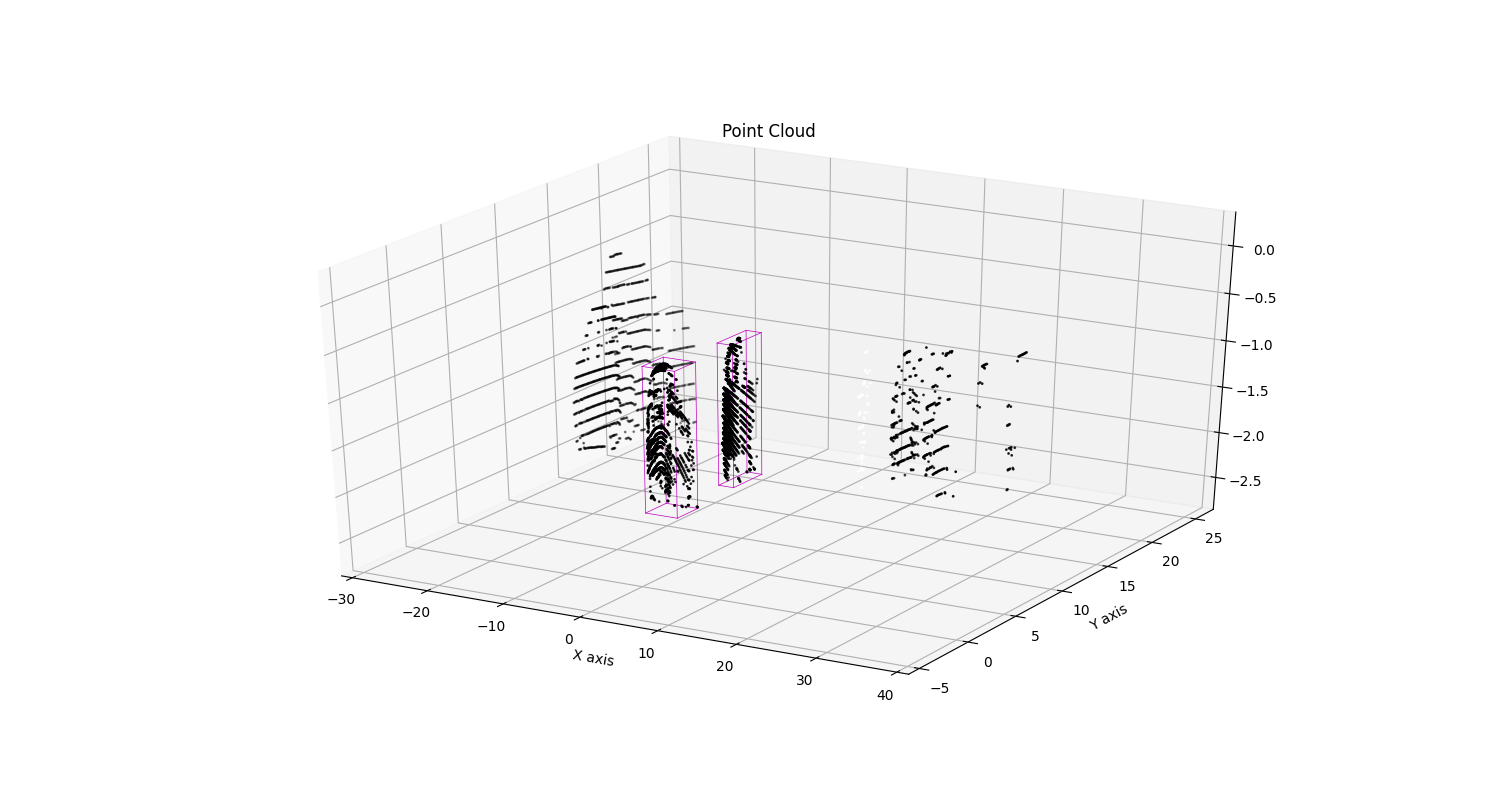

In [254]:
f = plt.figure(figsize=(15, 8))
ax = f.add_subplot(111, projection='3d') 
draw_point_cloud(pcloud_pcl, ax, 'Point Cloud', xlim3d=(-30,40))
for box in bboxes:
     draw_box(ax, box, axes=[0, 1, 2], color='m')
plt.show()

In [209]:
scan1 = scan[:,:3]
test_cloud = pyntcloud.PyntCloud(pcloud)
test_cloud.plot(backend='pythreejs', use_as_color='seg_id')

/opt/conda/lib/python3.7/site-packages/pythreejs/traits.py:191: UserWarning: 64-bit data types not supported for WebGL data, casting to 32-bit.
  warnings.warn('64-bit data types not supported for WebGL '


Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.6519368392810571, 11.051446094267941, -0.…